In [ ]:
# Standard libraries
import os
import json
import numpy as np
from typing import List, Dict, Optional

# Graph Libraries
import networkx as nx

# OpenAI
from openai import OpenAI

openai_api_key = 'api key goes here'

In [10]:
def load_aviation_graph(graph_path: str = 'knowledge_graph.gml') -> nx.Graph:
    """
    Load the existing aviation maintenance knowledge graph.

    Args:
        graph_path (str): Path to the .gml graph file

    Returns:
        nx.Graph: Loaded NetworkX graph
    """
    try:
        graph = nx.read_gml(graph_path)
        print(f"Graph loaded successfully!")
        print(f"Number of nodes: {graph.number_of_nodes()}")
        print(f"Number of edges: {graph.number_of_edges()}")
        return graph
    except Exception as e:
        print(f"Error loading graph: {e}")
        return None

# Load the graph
graph = load_aviation_graph()

# Print sample of nodes and edges if graph loaded successfully
if graph:
    print("\nSample of nodes:")
    for node in list(graph.nodes())[:5]:
        print(f"Node: {node}")
        print(f"Attributes: {graph.nodes[node]}\n")

    print("\nSample of edges:")
    for edge in list(graph.edges(data=True))[:5]:
        print(f"Edge: {edge}")

Graph loaded successfully!
Number of nodes: 468
Number of edges: 278

Sample of nodes:
Node: ACFT
Attributes: {'type': 'VEHICLE', 'incident_ids': ['19990213001379A', '19780111000459A', '19990213001379A', '19990213001379A', '19780111000459A']}

Node: TAKEOFF
Attributes: {'type': 'PHASE', 'incident_ids': ['19800217031649I', '20070630826079I', '19991230042089A', '19820725041999I', '19860706034879A', '19840121015319I', '19870606018859A', '19870319012959I', '19970523014439I', '19930530020029I', '19920405008919A', '19840821046409A', '19960524045629A', '20060621012279A', '20010411006739I', '19970828026989A', '19800217031649I', '20070630826079I', '19991230042089A', '19820725041999I', '19860706034879A', '19840121015319I', '19780913017419I', '19870606018859A', '19870319012959I', '19970523014439I', '19930530020029I', '19930530020029I', '19920405008919A', '19840821046409A', '19950216008379I', '19960524045629A', '19800506012169A', '20060621012279A', '20010411006739I', '19970828026989A']}

Node: ENG

Graph too large, showing first 100 nodes

Graph Statistics:
Total nodes: 468
Total edges: 278
Average degree: 1.19


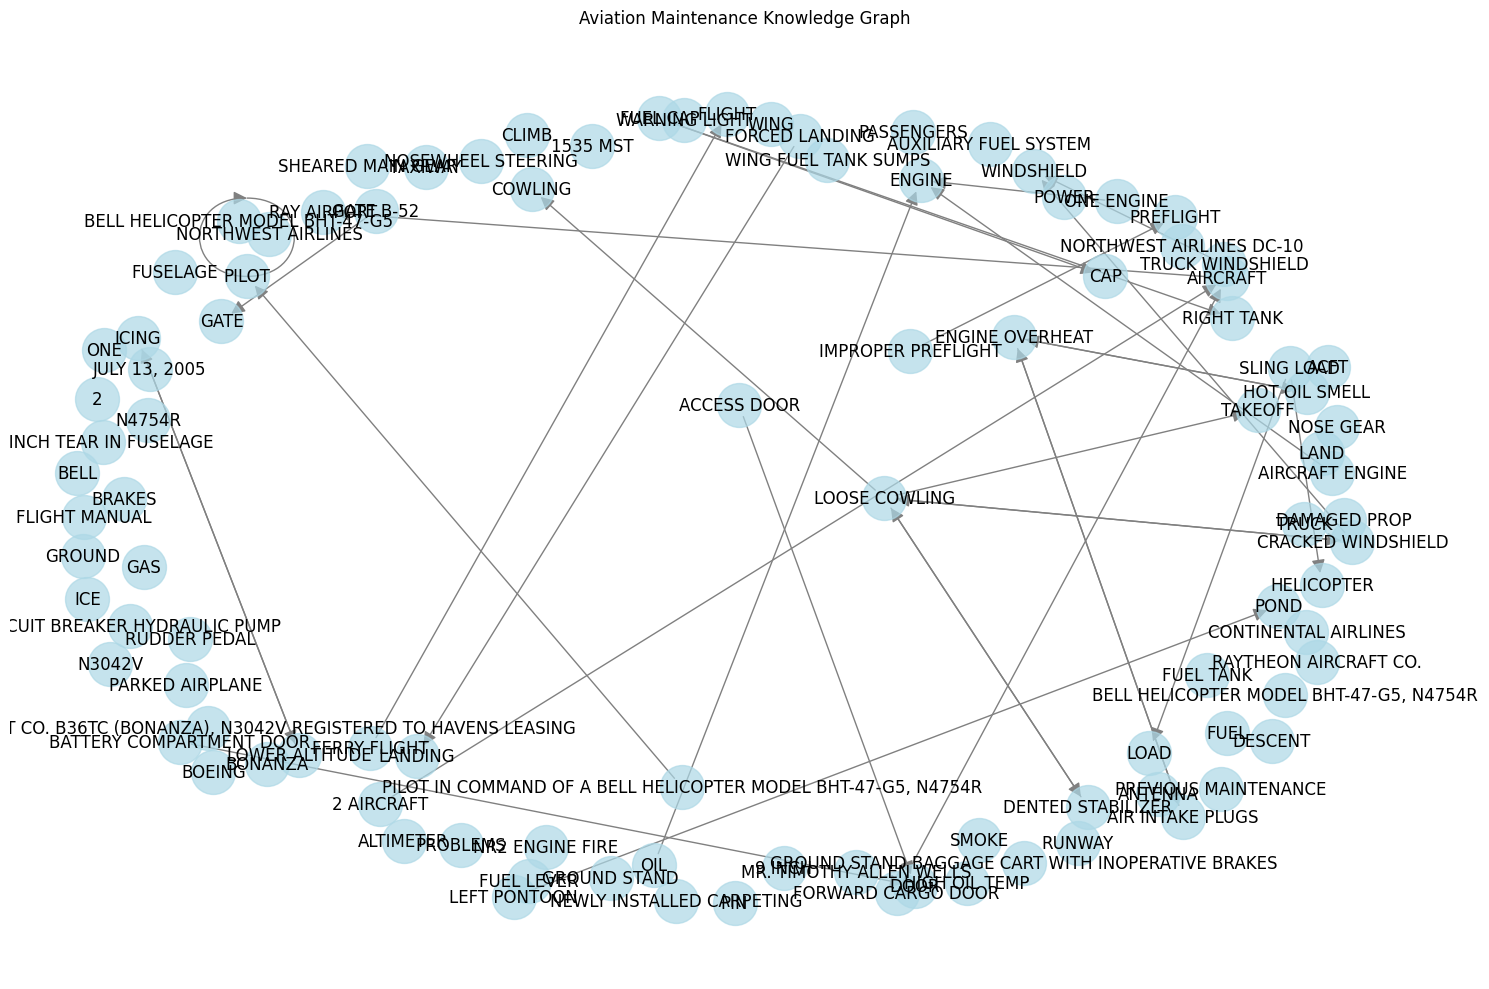

In [12]:
def visualize_graph(graph: nx.Graph,
                   max_nodes: int = 100,
                   node_size: int = 1000,
                   font_size: int = 12,
                   figure_size: tuple = (15, 10)):
    """
    Visualize the aviation maintenance knowledge graph.

    Args:
        graph (nx.Graph): The loaded knowledge graph
        max_nodes (int): Maximum number of nodes to display for readability
        node_size (int): Size of nodes in visualization
        font_size (int): Size of label font
        figure_size (tuple): Size of the figure (width, height)
    """
    try:
        # Create subset if graph is too large
        if graph.number_of_nodes() > max_nodes:
            print(f"Graph too large, showing first {max_nodes} nodes")
            nodes = list(graph.nodes())[:max_nodes]
            graph_vis = graph.subgraph(nodes)
        else:
            graph_vis = graph

        # Setup the visualization
        plt.figure(figsize=figure_size)
        pos = nx.spring_layout(graph_vis, k=1, iterations=50)

        # Draw nodes
        nx.draw_networkx_nodes(graph_vis, pos,
                             node_color='lightblue',
                             node_size=node_size,
                             alpha=0.7)

        # Draw edges with relationship types
        edge_labels = {}
        for u, v, data in graph_vis.edges(data=True):
            # Get relationship type from edge data
            rel_type = data.get('relationship', '')
            if rel_type:
                edge_labels[(u, v)] = rel_type

        nx.draw_networkx_edges(graph_vis, pos,
                             edge_color='gray',
                             arrows=True,
                             arrowsize=20)

        # Add labels
        nx.draw_networkx_labels(graph_vis, pos,
                              font_size=font_size)
        nx.draw_networkx_edge_labels(graph_vis, pos,
                                   edge_labels=edge_labels,
                                   font_size=font_size-2)

        plt.title("Aviation Maintenance Knowledge Graph")
        plt.axis('off')
        plt.tight_layout()

        # Show graph statistics
        print(f"\nGraph Statistics:")
        print(f"Total nodes: {graph.number_of_nodes()}")
        print(f"Total edges: {graph.number_of_edges()}")
        print(f"Average degree: {sum(dict(graph.degree()).values())/graph.number_of_nodes():.2f}")

        plt.show()

    except Exception as e:
        print(f"Error visualizing graph: {e}")

# Example usage
if graph:  # Only if graph was loaded successfully
    visualize_graph(graph)

In [19]:
class GraphRetriever:
    def __init__(self, graph: nx.Graph, openai_api_key: str):
        """
        Initialize the graph retriever with weights for hybrid search.

        Args:
            graph (nx.Graph): Loaded knowledge graph
            openai_api_key (str): OpenAI API key for embeddings
        """
        self.graph = graph
        self.openai_client = OpenAI(api_key=openai_api_key)

        # Configuration for hybrid search
        self.config = {
            'semantic_weight': 0.4,      # α: Weight for semantic similarity
            'path_weight': 0.4,          # β: Weight for path-based relevance
            'edge_weight': 0.2,          # γ: Weight for edge type importance
            'max_path_length': 3,        # Maximum path length to consider
            'embedding_model': "text-embedding-3-small"
        }

        # Cache for embeddings
        self.embeddings = {}

        # Edge type importance (can be customized)
        self.edge_importance = {
            'has_part': 1.0,
            'causes': 0.9,
            'requires': 0.8,
            'affects': 0.7,
            'related_to': 0.5
        }

    def generate_embeddings(self):
        """
        Generate and cache embeddings for all nodes
        """
        try:
            # Load cache if exists
            if os.path.exists('embeddings_cache.json'):
                with open('embeddings_cache.json', 'r') as f:
                    self.embeddings = json.load(f)
                print("Loaded embeddings from cache")

            # Generate embeddings for new nodes
            new_nodes = set(self.graph.nodes()) - set(self.embeddings.keys())
            if new_nodes:
                print(f"Generating embeddings for {len(new_nodes)} new nodes")
                for node in new_nodes:
                    # Include node attributes in embedding context
                    node_context = f"{node} {str(self.graph.nodes[node])}"
                    response = self.openai_client.embeddings.create(
                        model=self.config['embedding_model'],
                        input=node_context,
                        encoding_format="float"
                    )
                    self.embeddings[node] = response.data[0].embedding

                # Save updated cache
                with open('embeddings_cache.json', 'w') as f:
                    json.dump(self.embeddings, f)

            print("Embeddings generated successfully")

        except Exception as e:
            print(f"Error generating embeddings: {e}")

    def calculate_semantic_similarity(self, query_embedding: List[float], node_embedding: List[float]) -> float:
        """
        Calculate cosine similarity between query and node embeddings
        """
        dot_product = np.dot(query_embedding, node_embedding)
        norm_product = np.linalg.norm(query_embedding) * np.linalg.norm(node_embedding)
        return dot_product / norm_product if norm_product != 0 else 0

    def calculate_path_weight(self, path: List[str]) -> float:
        """
        Calculate the weight of a path based on edge weights and types
        """
        if len(path) < 2:
            return 0

        total_weight = 1.0
        for i in range(len(path) - 1):
            edge_data = self.graph.get_edge_data(path[i], path[i+1])
            if edge_data:
                # Consider both edge weight and type importance
                edge_weight = edge_data.get('weight', 1.0)
                edge_type = edge_data.get('relationship', 'related_to')
                type_importance = self.edge_importance.get(edge_type, 0.5)
                total_weight *= edge_weight * type_importance

        return total_weight

    def find_relevant_paths(self, start_node: str, max_length: int = None) -> List[List[str]]:
        """
        Find relevant paths from a start node
        """
        if max_length is None:
            max_length = self.config['max_path_length']

        paths = []
        for node in self.graph.nodes():
            if node != start_node:
                try:
                    for path in nx.all_simple_paths(self.graph, start_node, node, cutoff=max_length):
                        paths.append(path)
                except nx.NetworkXNoPath:
                    continue
        return paths

    def retrieve(self, query: str, k: int = 5) -> List[Dict]:
        """
        Retrieve relevant nodes using hybrid approach

        Args:
            query (str): Search query
            k (int): Number of results to return

        Returns:
            List[Dict]: Ranked relevant results with scores and paths
        """
        try:
            # Generate query embedding
            query_response = self.openai_client.embeddings.create(
                model=self.config['embedding_model'],
                input=query,
                encoding_format="float"
            )
            query_embedding = query_response.data[0].embedding

            # Calculate scores for all nodes
            results = []
            for node in self.graph.nodes():
                if node not in self.embeddings:
                    continue

                # Calculate semantic similarity
                semantic_score = self.calculate_semantic_similarity(
                    query_embedding,
                    self.embeddings[node]
                )

                # Find relevant paths
                paths = self.find_relevant_paths(node)
                path_scores = [self.calculate_path_weight(path) for path in paths]
                max_path_score = max(path_scores) if path_scores else 0

                # Calculate hybrid score
                hybrid_score = (
                    self.config['semantic_weight'] * semantic_score +
                    self.config['path_weight'] * max_path_score
                )

                results.append({
                    'node': node,
                    'score': hybrid_score,
                    'semantic_similarity': semantic_score,
                    'paths': paths,
                    'attributes': self.graph.nodes[node]
                })

            # Sort by score and return top k
            results.sort(key=lambda x: x['score'], reverse=True)
            return results[:k]

        except Exception as e:
            print(f"Error in retrieval: {e}")
            return []

    def query(self, query: str, k: int = 5) -> Dict:
        """
        Perform a query and return structured results

        Args:
            query (str): Search query
            k (int): Number of results

        Returns:
            Dict: Structured query results with context
        """
        results = self.retrieve(query, k)

        response = {
            'query': query,
            'results': results,
            'related_contexts': set(),
            'maintenance_paths': []
        }

        # Collect related contexts and maintenance paths
        for result in results:
            node = result['node']

            # Add node context
            if 'context' in result['attributes']:
                response['related_contexts'].add(result['attributes']['context'])

            # Add maintenance paths
            for path in result['paths']:
                if len(path) > 1:
                    path_info = {
                        'path': path,
                        'weight': self.calculate_path_weight(path),
                        'relationships': []
                    }

                    # Add relationships along the path
                    for i in range(len(path) - 1):
                        edge_data = self.graph.get_edge_data(path[i], path[i+1])
                        if edge_data:
                            path_info['relationships'].append(edge_data.get('relationship', 'related_to'))

                    response['maintenance_paths'].append(path_info)

        return response
    # Add this method to the GraphRetriever class
    def generate_structured_answer(self, query: str, results: Dict, max_context: int = 3) -> str:
        """
        Generate a coherent answer from the graph retrieval results using GPT.

        Args:
            query (str): Original query
            results (Dict): Results from retriever
            max_context (int): Maximum number of context paths to include

        Returns:
            str: Structured answer to the query
        """
        try:
            # Format context from results
            context = "Based on the maintenance records analysis:\n\n"

            # Add top findings
            for i, result in enumerate(results['results'][:max_context], 1):
                context += f"{i}. Found: {result['node']}\n"

                # Add relevant paths if available
                if result['paths']:
                    context += "   Related information:\n"
                    for path in result['paths'][:2]:
                        context += f"   - {' -> '.join(path)}\n"

                # Add maintenance context if available
                if 'maintenance_paths' in results:
                    for path_info in results['maintenance_paths']:
                        if result['node'] in path_info['path']:
                            context += f"   Maintenance context: {' -> '.join(path_info['path'])}\n"

                context += "\n"

            # Create prompt for GPT
            prompt_message = [
                {
                    "role": "system",
                    "content": """You are an aviation maintenance expert. Provide clear, technical,
                    but understandable answers based on the maintenance records analysis. Focus on:
                    - Direct answers to the question
                    - Technical accuracy
                    - Maintenance implications
                    - Common patterns or issues identified
                    Keep the response concise but informative."""
                },
                {
                    "role": "user",
                    "content": f"""Question: {query}\n\nAnalysis Results:\n{context}

                    Please provide a clear, technical answer based on this maintenance data.
                    Focus on answering the specific question while including relevant technical context."""
                }
            ]

            # Generate response
            response = self.openai_client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=prompt_message,
                temperature=0.7,
                max_tokens=300
            )

            return response.choices[0].message.content.strip()

        except Exception as e:
            print(f"Error generating structured answer: {e}")
            return f"Error processing results: {str(e)}"

In [21]:
def generate_structured_answer(self, query: str, results: Dict, max_context: int = 3) -> str:
    """
    Generate a coherent answer from the graph retrieval results using GPT.

    Args:
        query (str): Original query
        results (Dict): Results from retriever
        max_context (int): Maximum number of context paths to include

    Returns:
        str: Structured answer to the query
    """
    try:
        # Format context from results
        context = "Based on the maintenance records analysis:\n\n"

        # Add top findings
        for i, result in enumerate(results['results'][:max_context], 1):
            context += f"{i}. Found: {result['node']}\n"

            # Add relevant paths if available
            if result['paths']:
                context += "   Related information:\n"
                for path in result['paths'][:2]:
                    context += f"   - {' -> '.join(path)}\n"

            # Add maintenance context if available
            if 'maintenance_paths' in results:
                for path_info in results['maintenance_paths']:
                    if result['node'] in path_info['path']:
                        context += f"   Maintenance context: {' -> '.join(path_info['path'])}\n"

            context += "\n"

        # Create prompt for GPT
        prompt_message = [
            {
                "role": "system",
                "content": """You are an aviation maintenance expert. Provide clear, technical,
                but understandable answers based on the maintenance records analysis. Focus on:
                - Direct answers to the question
                - Technical accuracy
                - Maintenance implications
                - Common patterns or issues identified
                Keep the response concise but informative."""
            },
            {
                "role": "user",
                "content": f"""Question: {query}\n\nAnalysis Results:\n{context}

                Please provide a clear, technical answer based on this maintenance data.
                Focus on answering the specific question while including relevant technical context."""
            }
        ]

        # Generate response
        response = self.openai_client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=prompt_message,
            temperature=0.7,
            max_tokens=300
        )

        return response.choices[0].message.content.strip()

    except Exception as e:
        print(f"Error generating structured answer: {e}")
        return f"Error processing results: {str(e)}"

In [23]:
def query():
   """
   Test the GraphRetriever with sample aviation maintenance queries
   """
   # Initialize retriever
   retriever = GraphRetriever(graph, openai_api_key)

   # Generate embeddings (this will use cache if available)
   print("Generating embeddings...")
   retriever.generate_embeddings()

   # Test queries
   test_queries = [
       "What are common issues with aircraft brakes?",
       "Describe problems related to cargo doors",
       "Show me incidents related to engine failures during takeoff",
       "What are maintenance issues during taxiing?",
       "What are common problems with warning lights?"
   ]

   print("\nTesting Queries:")
   print("-" * 50)

   for query in test_queries:
       print(f"\nQuery: {query}")
       results = retriever.query(query, k=3)

       print("\nTop Results:")
       for i, result in enumerate(results['results'], 1):
           print(f"\n{i}. Node: {result['node']}")
           print(f"   Score: {result['score']:.3f}")
           print(f"   Semantic Similarity: {result['semantic_similarity']:.3f}")

           if result['paths']:
               print("\n   Relevant Paths:")
               for path in result['paths'][:2]:  # Show first 2 paths
                   print(f"   - {' -> '.join(path)}")

       if results['maintenance_paths']:
           print("\nMaintenance Context:")
           for path_info in results['maintenance_paths'][:2]:
               path = path_info['path']
               relationships = path_info['relationships']
               weight = path_info['weight']
               print(f"   - Path: {' -> '.join(path)}")
               print(f"   - Relationships: {relationships}")
               print(f"   - Path Weight: {weight:.3f}")

       # Generate and show structured answer
       print("\nStructured Answer:")
       print("-" * 50)
       answer = retriever.generate_structured_answer(query, results)
       print(answer)
       print("-" * 50)

def main():
   """
   Main execution function
   """
   print("Starting GraphRetriever test...")
   try:
       # Run the test
       query()
   except Exception as e:
       print(f"Error in main execution: {e}")

if __name__ == "__main__":
   main()

Starting GraphRetriever test...
Generating embeddings...
Loaded embeddings from cache
Embeddings generated successfully

Testing Queries:
--------------------------------------------------

Query: What are common issues with aircraft brakes?

Top Results:

1. Node: BRAKE PROBLEMS ON THE AIRCRAFT
   Score: 0.438
   Semantic Similarity: 0.595

   Relevant Paths:
   - BRAKE PROBLEMS ON THE AIRCRAFT -> BRAKE PROBLEMS -> AIRCRAFT
   - BRAKE PROBLEMS ON THE AIRCRAFT -> BRAKE PROBLEMS -> AIRCRAFT -> RAY AIRPORT

2. Node: BRAKE PROBLEMS
   Score: 0.393
   Semantic Similarity: 0.482

   Relevant Paths:
   - BRAKE PROBLEMS -> AIRCRAFT
   - BRAKE PROBLEMS -> AIRCRAFT -> RAY AIRPORT

3. Node: WORN OUT & INEFFECTIVE BRAKES
   Score: 0.392
   Semantic Similarity: 0.480

   Relevant Paths:
   - WORN OUT & INEFFECTIVE BRAKES -> BRAKES
   - WORN OUT & INEFFECTIVE BRAKES -> BRAKES -> CART

Maintenance Context:
   - Path: BRAKE PROBLEMS ON THE AIRCRAFT -> BRAKE PROBLEMS -> AIRCRAFT
   - Relationships: ['